# **Tranfer Learning sur la base de donnée euroSAT**

In [2]:
import torch
import tensorflow


ModuleNotFoundError: No module named 'tensorflow'

In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [15]:
!nvidia-smi

Sat Apr  4 15:32:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Etape 2 : Migration des images sur le Google Drive

Il faut créer un dossier data dans le menu Files
Ensuite on vient importer les bases de donnée data_ezzor.csv et images_label_ezzor
On importe finalement quelques images d'Ezzor afin de tester la validité du modèle

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
!unzip /images.zip

Archive:  /images.zip
   creating: images/
   creating: images/ezzor/
   creating: images/ezzor/.ipynb_checkpoints/
  inflating: images/ezzor/.ipynb_checkpoints/ezzor_40.0933845632999_35.34675575428853-checkpoint.jpg  
  inflating: images/ezzor/.ipynb_checkpoints/ezzor_40.0933845632999_35.347941525039516-checkpoint.jpg  
  inflating: images/ezzor/.ipynb_checkpoints/ezzor_40.09660482181983_35.32541188077078-checkpoint.jpg  
  inflating: images/ezzor/.ipynb_checkpoints/ezzor_40.0982149510798_35.330154963774724-checkpoint.jpg  
  inflating: images/ezzor/.ipynb_checkpoints/ezzor_40.13202766553908_35.33134073452571-checkpoint.jpg  
  inflating: images/ezzor/.ipynb_checkpoints/ezzor_40.13202766553908_35.3325265052767-checkpoint.jpg  
  inflating: images/ezzor/.ipynb_checkpoints/ezzor_40.13202766553908_35.33371227602768-checkpoint.jpg  
  inflating: images/ezzor/.ipynb_checkpoints/ezzor_40.1497390873987_35.314739944011905-checkpoint.jpg  
  inflating: images/ezzor/.ipynb_checkpoints/ezzor_40.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'images/ezzor'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [ ]:
len(image_datasets['train'])

1085

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [56]:
device

device(type='cuda', index=0)

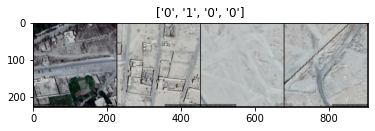

In [99]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [101]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [100]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()
  #num_epochs = 4
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  #labels_train=[]
  #labels_test=[]
  #preds_train=[]
  #preds_test=[]

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'test']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]: #use of dataloaders from previous step
              inputs = inputs.to(device)
              labels = labels.to(device)
              
              # if phase == 'train':
              #   labels_train += list(labels.detach().cpu().numpy())
              # if phase == 'test':
              #   labels_test += list(labels.detach().cpu().numpy())

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  # if phase == 'train':
                  #   preds_train += list(preds.detach().cpu().numpy())
                  # if phase == 'test':
                  #   preds_test += list(preds.detach().cpu().numpy())

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
              scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
              phase, epoch_loss, epoch_acc))

          #deep copy the model
          if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

      print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best test Acc: {:4f}'.format(best_acc))

  # load best model weights
  return model.load_state_dict(best_model_wts)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [110]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7094 Acc: 0.6949
test Loss: 0.8944 Acc: 0.6557

Epoch 1/24
----------
train Loss: 0.6468 Acc: 0.7290
test Loss: 0.6676 Acc: 0.6455

Epoch 2/24
----------
train Loss: 0.5621 Acc: 0.7705
test Loss: 0.6501 Acc: 0.7787

Epoch 3/24
----------
train Loss: 0.5275 Acc: 0.7594
test Loss: 0.6260 Acc: 0.7889

Epoch 4/24
----------
train Loss: 0.5433 Acc: 0.7853
test Loss: 0.5501 Acc: 0.7766

Epoch 5/24
----------
train Loss: 0.5040 Acc: 0.8000
test Loss: 0.6210 Acc: 0.8156

Epoch 6/24
----------
train Loss: 0.4692 Acc: 0.8184
test Loss: 1.5448 Acc: 0.5205

Epoch 7/24
----------
train Loss: 0.3049 Acc: 0.8903
test Loss: 0.5402 Acc: 0.8012

Epoch 8/24
----------
train Loss: 0.2624 Acc: 0.9041
test Loss: 0.5472 Acc: 0.8012

Epoch 9/24
----------
train Loss: 0.2222 Acc: 0.9041
test Loss: 0.5455 Acc: 0.7992

Epoch 10/24
----------
train Loss: 0.2344 Acc: 0.9060
test Loss: 0.5626 Acc: 0.7910

Epoch 11/24
----------
train Loss: 0.2243 Acc: 0.9124
test Loss: 0.5805 Acc

In [78]:
labels.detach().cpu().numpy()

array([0, 0, 1, 0])

In [68]:
outputs

tensor([[ 2.0254, -1.5930],
        [ 2.2064, -1.5817],
        [-0.0636,  0.5680],
        [ 0.1043,  0.0038]], device='cuda:0')

In [65]:
preds

tensor([0, 0, 1, 0], device='cuda:0')

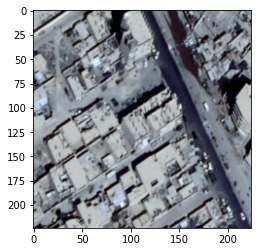

In [72]:
for img in inputs:
  plt.imshow(img.detach().cpu().numpy().transpose((1, 2, 0)))

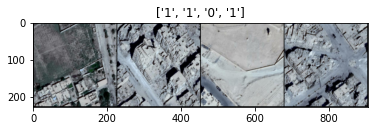

In [87]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs_2, classes = (inputs.detach().cpu(), labels.detach().cpu())

# Make a grid from batch
out = torchvision.utils.make_grid(inputs_2)

imshow(out, title=[class_names[x] for x in classes])

In [88]:
preds

tensor([1, 1, 0, 1], device='cuda:0')

In [ ]:
from sklearn.metrics import confusion_matrix

In [96]:
confusion_matrix(labels_test, preds_test)

array([[1062,  194],
       [ 240,  456]])